# Principal Component Analysis

*Kevin Yip*

*2018-07-14*



Principal component analysis (PCA) is a method for finding a low-dimensional representation that maximally resembles an input matrix. There are many different methods for finding low-dimensional representations, depending on how the resemblance to the original matrix is quantified. In PCA, resemblance is quantified by the amount of variance among the data points retained. Specifically, if the matrix is to be represented in one dimension (defined by a unit vector called the first principal component or PC), PCA guarantees that the variance of the data points when projected onto this PC is largest among all possible unit vectors. Each subsequent PC is defined as a unit vector orthogonal to all previous PCs that gives the largest variance when the data points are projected onto it.

Usually, a small number of PCs are used to represent the data for several reasons:

* Directions that do not capture a lot of variance are considered uninformative and thus can be ignored.
* A low-dimensional representation allows more efficient computations.
* A two- or three-dimensional representation makes it easy to visualize the data.

Practically, a standard practice is to select a certain number of PCs such that including additional PCs would only retain a small amount of extra variance.

Before going into the technical details, let us start with a simple example. Suppose we have the following 1000 data points in a 2-dimensional space. The size of the corresponding data matrix is 1000 (rows) $\times$ 2 (columns):


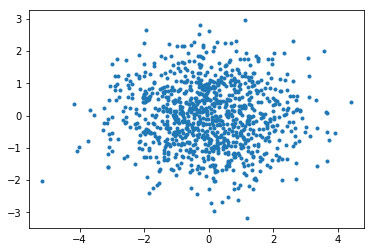

In [439]:
# Load the numpy library for scientific computing
import numpy as np
# Load the matplotlib.pyplot library for making plots
import matplotlib.pyplot as plt

# Generate a set of points based on a 2D Gaussian distribution, stored as (x,y)
means = [0, 0]
covs  = [[2, 0], [0, 1]]
xs, ys = np.random.multivariate_normal(means, covs, 1000).T

# Plot the points with equal scales for the x and y axes
plt.plot(xs, ys, '.')
plt.axis('equal')
plt.show()

In this example, the points are generated in a way that their x and y coordinates are independent, and the data points have a variance along the x-axis twice of that along the y-axis. Based on the definition of PCA, if we want to find one PC, it should be a vector nearly in parallel to the x-axis (and exactly parallel to the x-axis if we have an infinite number of points). Let us verify this by using a built-in PCA function of the sklearn library:

In [440]:
# Import the PCA module
from sklearn.decomposition import PCA

# Create a PCA object involving only one PC
pca = PCA(n_components=1)
# Put x and y together into a matrix A
A = np.array([xs, ys]).T
# Determine the first PC of A and print it
pca.fit(A)
print("PC1 of A: ", pca.components_[0])

PC1 of A:  [-0.9991711  0.0407076]


The resulting PC is indeed almost parallel to the x-axis, with an almost zero second element (i.e., zero "loading" of the second column). Notice that the sign of the PC (towards the positive or negative side) is arbitrary, and different libraries may have different implementations.

If we project every point onto this PC, we get the one-dimensional representation that preserves the largest amount of variance among the points as shown in the figure below (the PC shown as black line, projections shown as red dots):

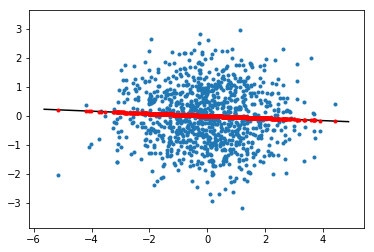

In [441]:
# Define a function for projecting a list of points onto the first PC
def pc1(xs):
    return np.divide(np.multiply(pca.components_[0][1], xs), pca.components_[0][0])

# Plot the original data points
plt.plot(xs, ys, '.')
plt.axis('equal')
# Draw a line of the first PC across the whole plotting area
xrange = plt.xlim()
plt.plot(xrange, pc1(xrange), 'black')
# Plot the projections
plt.plot(xs, pc1(xs), 'r.')
plt.show()

Now, let's see how we can find out the PCs mathematically in general. We start with the first PC. Let $A$ be the data matrix of size $n\times m$, and the first PC is a length-$m$ unit vector $\alpha_1$ such that the projection $A\alpha_1$ has the largest variance among all length-$m$ unit vectors. We want the vector to be of unit length because the variance can trivially be made larger by having an $\alpha_1$ with a larger magnitude.

The variance of $A\alpha_1$ turns out to be proportional to $\alpha_1^TA^TA\alpha_1$ if $A$ is mean-centred, i.e., it has zero mean along every dimension. This is because the variance of $A\alpha_1$, $var(A\alpha_1) \propto \sum_{i=1}^n [(A\alpha_1)_i - \overline{A\alpha_1}]^2 = \sum_{i=1}^n (A\alpha_1)_i^2 = (A\alpha_1)^T(A\alpha_1) = \alpha_1^TA^TA\alpha_1$. In the equation, $\overline{A\alpha_1}$ is the mean of $A\alpha_1$, which is equal to zero if $A$ is mean-centered since it is simply a weighted sum of the means of the different columns, which are all zero. Again, due to mean centering, we can see that $\Sigma \stackrel{\text{def}}{=} A^TA$ is the covariance matrix of $A$, where entry $\Sigma_{ij}$ corresponds to the covariance of the $i$-th and $j$-th columns of $A$.

Taking all these together, the first PC can be defined as $\arg\max_{\alpha_1:\alpha_1^t\alpha_1=1} \alpha_1^TA^TA\alpha_1$.

To determine $\alpha_1$, we use a Lagrange multiplier $\lambda_1$, which gives $\nabla \alpha_1^TA^TA\alpha_1 - \nabla\lambda_1 (\alpha_1^T\alpha_1 - 1) = 0$ as a necessary condition. Differentiating with respect to $\alpha_1$ gives $(A^TA)\alpha_1 - \lambda_1\alpha_1 = 0$ or $(A^TA)\alpha_1 = \lambda_1\alpha_1$. To satisfy this equation, $\lambda_1$ should take an eigenvalue of the covariance matrix $A^TA$ and $\alpha_1$ should be the corresponding eigenvector. Since $var(A\alpha_1) = \alpha_1^TA^TA\alpha_1 = \alpha_1^T\lambda_1\alpha_1 = \lambda_1\alpha_1^T\alpha_1 = \lambda_1$, to maximize the variance of $A\alpha_1$, $\lambda_1$ shuold take the largest eigenvalue and thus the first PC of $A$ is the same as the first eigenvector of $A^TA$.

Let's use our example to check this:

In [442]:
# Load the linalg library for linear algebra operations
import numpy.linalg as la

# Perform eigenvalue decomposition of $A^TA$
result = la.eig(np.matmul(A.T, A))
# Print the first eigenvector
# In th first index, 0 is for eigenvalues and 1 is for eigenvectors
print("First eigenvector of A^TA: ", result[1][0])
print("PC1 of A (copied from above): ", pca.components_[0])

First eigenvector of A^TA:  [0.99917731 0.04055504]
PC1 of A (copied from above):  [-0.9991711  0.0407076]


This first eigenvector of $A^TA$ is very close to the first PC of $A$ we obtained previously (when the sign is ignored), with the small difference between them due to small but non-zero means of the columns of $A$.

Now, we work on the second PC $\alpha_2$. PCA requires that this second PC should be orthogonal to the first PC, which can be written as the constraint $\alpha_2^T\alpha_1 = 0$. Again, using Lagrange multipliers $\lambda_2$ and $\phi_2$, we have $\nabla \alpha_2^TA^TA\alpha_2 - \nabla\lambda_2 (\alpha_2^T\alpha_2 - 1) - \nabla\phi_2 (\alpha_2^T\alpha_1) = 0$ as a necessary condition. Differentiating with respect to $\alpha_2$ gives $(A^TA)\alpha_2 - \lambda_2\alpha_2 - \phi_2\alpha_1 = 0$. Now multiplying $\alpha_1$ from the left gives $\alpha_1^T(A^TA)\alpha_2 - \alpha_1^T\lambda_2\alpha_2 - \alpha_1^T\phi_2\alpha_1 = 0$, where:

* The first term is zero (because $\alpha_1^T(A^TA)\alpha_2 = (A^TA\alpha_1)^T\alpha_2 = (\lambda_1\alpha_1)^T\alpha_2 = 0$ due to orthogonal PCs)
* The second term is zero (due to orthogonal PCs)
* In the third term, $\alpha_1^T\alpha_1 = 1$ (due to the unit length requirement)

Therefore $\phi$ must equal zero and thus $(A^TA)\alpha_2 = \lambda_2\alpha_2$. This means $\alpha_2$ must also be an eigenvector of $A^TA$ and in order to maximize $var(A\alpha_2) = \lambda_2$, $\lambda_2$ should be the second largest eigenvalue of $A^TA$ and $\alpha_2$ should be the corresponding eigenvector.

In general, the $k$-th PC of $A$ is the eigenvector of $A^TA$ corresponding to the $k$-th largest eigenvalue.

Let's see a new example in 3D:

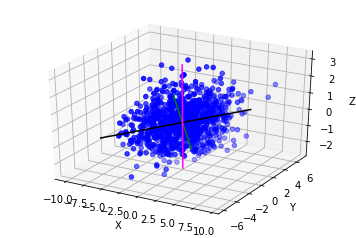

PC1 of A:  [0.68392046 0.7295314  0.00606148]
PC2 of A:  [-0.72827059  0.68318445 -0.05367452]
PC3 of A:  [-0.04329836  0.0322947   0.99854009]


In [443]:
# Load the mpl_toolkits.mplot3d library for 3D plotting
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate a set of points based on a 3D Gaussian distribution, stored as (x,y,z)
means = [0, 0, 0]
covs  = [[4, 2, 0], [2, 4, 0], [0, 0, 1]]
xs, ys, zs = np.random.multivariate_normal(means, covs, 1000).T

# Make a scatterplot of the points
ax.scatter(xs, ys, zs, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis('equal')

# Determine the PCs
pca = PCA(n_components=3)
# Put x, y and z together into a matrix A
A = np.array([xs, ys, zs]).T
# Determine the PCs of A
pca.fit(A)

# Plot the PCs
xange = (min(xs), max(xs))  # PC1
ax.plot(xrange,
        np.divide(np.multiply(pca.components_[0][1], xrange), pca.components_[0][0]),
        np.divide(np.multiply(pca.components_[0][2], xrange), pca.components_[0][0]),
        'black')
yrange = (min(ys), max(ys)) # PC2
ax.plot(np.divide(np.multiply(pca.components_[1][0], yrange), pca.components_[1][1]),
        yrange,
        np.divide(np.multiply(pca.components_[1][2], yrange), pca.components_[1][1]),
        'green')
zrange = (min(zs), max(zs)) # PC3
ax.plot(np.divide(np.multiply(pca.components_[2][0], zrange), pca.components_[2][2]),
        np.divide(np.multiply(pca.components_[2][1], zrange), pca.components_[2][2]),
        zrange,
        'magenta')

# Set the axis limits and show the plot
ax.set_xlim3d(xrange)
ax.set_ylim3d(yrange)
ax.set_zlim3d(zrange)
plt.show()

# Print the PCs
print("PC1 of A: ", pca.components_[0])
print("PC2 of A: ", pca.components_[1])
print("PC3 of A: ", pca.components_[2])

In this example, the points are generated in a way that their projections on the x-y plane is a ellipse with the major axis alone the y=x line. The z coordinates of the points are generated independently of the x- and y-coordinates and with a small variance. As a result, the first PC (black line) is roughly y=x, the second PC (green line) is roughly y=-x, and the third PC (magenta line) is roughly parallel to the z-axis.

Finally, we revisit the mean-centering issue. If the input matrix does not have zero column means, we can mean-center it by subtracting the numbers in each column by their mean. What would happen if we do not mean-center a matrix? Let's see another example, which is similar to the first one above but with the points shifted towards the positive direction along y=x:

PC1 of A:  [0.99999201 0.00399854]
First eigenvector of A^TA:  [ 0.71384049 -0.70030833]


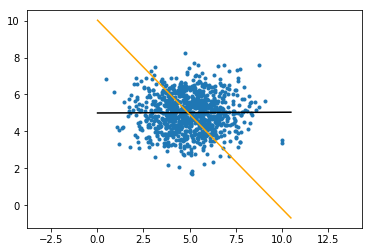

In [444]:
# Generate a set of points based on a 2D Gaussian distribution, stored as (x,y)
means = [5, 5]
covs  = [[2, 0], [0, 1]]
xs, ys = np.random.multivariate_normal(means, covs, 1000).T

# Plot the points with equal scales for the x and y axes
plt.plot(xs, ys, '.')
plt.axis('equal')

# Create a PCA object involving only one PC
pca = PCA(n_components=1)
# Put x and y together into a matrix A
A = np.array([xs, ys]).T
# Determine the first PC of A and print it
pca.fit(A)
print("PC1 of A: ", pca.components_[0])
# Plot PC1
xrange = plt.xlim()
plt.plot(xrange, np.divide(np.multiply(pca.components_[0][1], xrange), pca.components_[0][0]) + means[1], 'black')

# Perform eigenvalue decomposition of $A^TA$
result = la.eig(np.matmul(A.T, A))
# Print the first eigenvector
# In th first index, 0 is for eigenvalues and 1 is for eigenvectors
print("First eigenvector of A^TA: ", result[1][0])
# Plot the eigenvector
plt.plot(xrange, np.divide(np.multiply(result[1][1], xrange), result[1][0]) + means[1] * 2, 'orange')
plt.show()

From the figure, PC1 (black line, shifted upward to match centroid of points) is roughly parallel to the x-axis, and thus it appears that the sklearn package first mean-centers matrix $A$ before finding the first eigenvector of the covariance matrix as the first PC. On the other hand, if we compute the first eigenvector of $A$ directly (orange line, also shifted to match centroid of points), it is very different from the expected first PC.

A take-home message of this result is that before performing a PCA, we first need to know 1) exactly what we want to find, 2) whether the data matrix is mean-centered and 3) whether the software package that you use automatically performs mean-centering of the data matrix. Without knowing these, the results obtained could be completely different from what you hope to get.